In [10]:
import os
import sys

PROJECT_DIR = "C:/Users/super/Desktop/AIHL_project/aidl-2025-project"
sys.path.append(PROJECT_DIR)
print(PROJECT_DIR)

C:/Users/super/Desktop/AIHL_project/aidl-2025-project


In [11]:
# Load dataset
from src.data.load_workout_data import load_workout_data
PROJECT_DIR = "C:/Users/super/Desktop/AIHL_project/aidl-2025-project"
image_dir = os.path.join(PROJECT_DIR, 'workout_dataset/images')
annotation_dir = os.path.join(PROJECT_DIR, 'workout_dataset/new_labels')
keypoints_array, images_array, bounding_boxes_array, classes_array = load_workout_data(image_dir=image_dir, annotation_dir=annotation_dir)
print(len(keypoints_array), len(images_array), len(bounding_boxes_array), len(classes_array))

Checking image: C:/Users/super/Desktop/AIHL_project/aidl-2025-project\workout_dataset/images\barbell biceps curl\barbell biceps curl_1000001.jpg
Expected annotation file: C:/Users/super/Desktop/AIHL_project/aidl-2025-project\workout_dataset/new_labels\barbell biceps curl\barbell biceps curl_1000001.txt
Checking image: C:/Users/super/Desktop/AIHL_project/aidl-2025-project\workout_dataset/images\barbell biceps curl\barbell biceps curl_100001.jpg
Expected annotation file: C:/Users/super/Desktop/AIHL_project/aidl-2025-project\workout_dataset/new_labels\barbell biceps curl\barbell biceps curl_100001.txt
Checking image: C:/Users/super/Desktop/AIHL_project/aidl-2025-project\workout_dataset/images\barbell biceps curl\barbell biceps curl_1000011.jpg
Expected annotation file: C:/Users/super/Desktop/AIHL_project/aidl-2025-project\workout_dataset/new_labels\barbell biceps curl\barbell biceps curl_1000011.txt
Checking image: C:/Users/super/Desktop/AIHL_project/aidl-2025-project\workout_dataset/imag

In [12]:
print(keypoints_array[0])
print(images_array[0])
print(bounding_boxes_array[0])
print(classes_array[0])

[[0.524567, 0.117087, 0.983323], [0.558409, 0.102889, 0.992557], [0.530581, 0.0913009, 0.577368], [0.620674, 0.172557, 0.997285], [0.0, 0.0, 0.0578301], [0.669786, 0.436631, 0.997244], [0.501232, 0.36792, 0.996484], [0.657868, 0.771478, 0.935063], [0.482892, 0.609277, 0.978927], [0.610987, 0.989577, 0.637858], [0.459563, 0.796943, 0.881614], [0.603892, 0.933817, 0.791806], [0.488061, 0.900847, 0.863718], [0.0, 0.0, 0.00840144], [0.0, 0.0, 0.015726], [0.0, 0.0, 0.000316994], [0.0, 0.0, 0.000516978]]
C:/Users/super/Desktop/AIHL_project/aidl-2025-project\workout_dataset/images\barbell biceps curl\barbell biceps curl_1000001.jpg
[0.40833300000000006, 0.0, 0.733333, 1.0]
barbell biceps curl


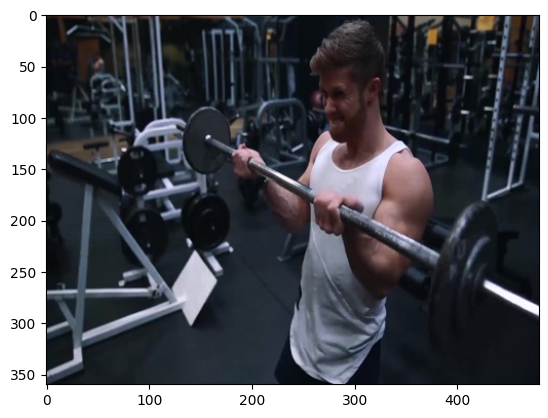

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

image = np.array(Image.open(images_array[7]))
plt.imshow(image)

In [14]:
!pip install torch
import torch
print (torch.__version__)

2.6.0+cpu



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from src.data.dataloader import create_dataloaders
# Create dataloaders
train_loader, val_loader, class_name_to_idx = create_dataloaders(images_array, bounding_boxes_array, keypoints_array, classes_array, batch_size=64, resize_to=[480, 360])

# Reverse the class_name_to_idx mapping
idx_to_class_name = {idx: class_name for class_name, idx in class_name_to_idx.items()}

# Check dataloaders
#print(len(train_loader), len(val_loader))
#print(train_loader.dataset[0])

Class (workout_label): tricep pushdown


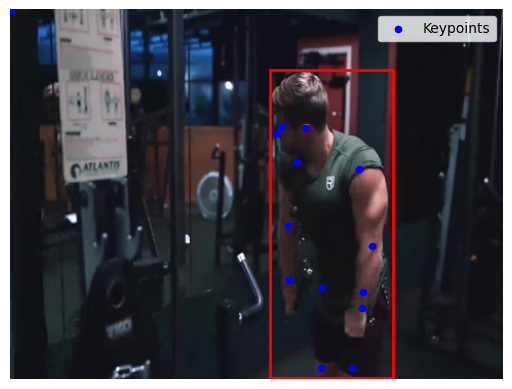

In [18]:
import torch
import matplotlib.pyplot as plt

image = train_loader.dataset[0][0].permute(1, 2, 0)
image = image.numpy()
plt.imshow(image)
plt.axis('off')


bbox = train_loader.dataset[0][1]['bbox'].numpy()
workout_label_name = train_loader.dataset[0][1]['workout_label_name']
keypoints = train_loader.dataset[0][1]['keypoints'].numpy()

h, w = image.shape[:2]
bbox = (bbox * np.array([w, h, w, h])).astype(int).flatten()

plt.gca().add_patch(plt.Rectangle(
    (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
    linewidth=2, edgecolor='red', facecolor='none'
))

keypoints[:, 0] *= w 
keypoints[:, 1] *= h 
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, c='blue', label='Keypoints')

print(f"Class (workout_label): {workout_label_name}")

plt.legend()
plt.show()

In [19]:
!pip install torchvision


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import torch.nn as nn
import torchvision
from src.data.dataloader import create_dataloaders

class Model(nn.Module):
    def __init__(self, num_classes, num_keypoints, use_resnet34=False):
        super(Model, self).__init__()

        self.num_classes = num_classes
        self.num_keypoints = num_keypoints

        if use_resnet34:
            self.backbone = torchvision.models.resnet34(pretrained=True)
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
            self.input_size = 512
        else:
            self.backbone = torchvision.models.resnet50(pretrained=True)
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
            self.input_size = 2048

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.bbox_head = nn.Sequential(
            nn.Linear(self.input_size , 512),
            nn.ReLU(),
            nn.Linear(512, 4)
        )

        self.keypoints_head = nn.Sequential(
            nn.Linear(self.input_size , 512),
            nn.ReLU(),
            nn.Linear(512, num_keypoints * 3)
        )

        self.workout_label_head = nn.Sequential(
            nn.Linear(self.input_size , 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
        # Global Average Pooling (GAP) layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        bbox = self.bbox_head(x)

        keypoints = self.keypoints_head(x).view(-1, self.num_keypoints, 3)
        keypoints = torch.sigmoid(keypoints)  
        # Apply thresholding to visibility (visibility = 1 if > 0.5, else 0)     
        keypoints_visibility = keypoints[:, :, 2]  # The visibility values are in the 3rd channel
        keypoints_visibility = (keypoints_visibility > 0.5).float()  # Set visibility to 1 or 0
        updated_keypoints = keypoints.clone()  # Clone the keypoints tensor
        updated_keypoints[:, :, 2] = keypoints_visibility

        workout_label = self.workout_label_head(x)

        return bbox, updated_keypoints, workout_label
    
    def compute_losses(self, outputs, targets):
        bbox_targets = torch.stack([target['bbox'] for target in targets])
        keypoints_targets = torch.stack([target['keypoints'] for target in targets])
        workout_label_targets = torch.stack([target['workout_label'] for target in targets])

        # Ajustar las dimensiones de keypoints_targets
        keypoints_targets = keypoints_targets[:, :, :3]  # Eliminar la cuarta dimensión

        # Verificar las dimensiones de los tensores
        print(f"outputs[0] shape: {outputs[0].shape}")
        print(f"bbox_targets shape: {bbox_targets.shape}")
        print(f"outputs[1] shape: {outputs[1].shape}")
        print(f"keypoints_targets shape: {keypoints_targets.shape}")
        print(f"outputs[2] shape: {outputs[2].shape}")
        print(f"workout_label_targets shape: {workout_label_targets.shape}")

        bbox_loss = nn.L1Loss()(outputs[0], bbox_targets)
        keypoints_loss = nn.L1Loss()(outputs[1], keypoints_targets)
        workout_label_indices = workout_label_targets.argmax(dim=1)
        workout_label_loss = nn.CrossEntropyLoss()(outputs[2], workout_label_indices)

        return bbox_loss, keypoints_loss, workout_label_loss

# Create dataloaders
train_loader, val_loader, class_name_to_idx = create_dataloaders(
    images_array, bounding_boxes_array, keypoints_array, classes_array, batch_size=64, resize_to=(480, 360)
)

# Reverse the class_name_to_idx mapping
idx_to_class_name = {idx: class_name for class_name, idx in class_name_to_idx.items()}

# Define the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_classes=len(class_name_to_idx), num_keypoints=17).to(device)  # Ajusta num_keypoints según tu dataset
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Initialize accumulators for accuracy metrics at the epoch level
    total_classification_correct = 0
    total_classification_count = 0
    total_bbox_correct = 0
    total_bbox_count = 0
    total_keypoints_correct = 0
    total_keypoints_count = 0

    for batch_idx, (images, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):

        images = images.to(device)
        new_targets = []
        
        for i in range(len(targets["bbox"])):  
            
            new_targets.append({
                "bbox": targets["bbox"][i].to(device),  
                "workout_label": targets["workout_label"][i].to(device),  
                "keypoints": targets["keypoints"][i].to(device), 
            })
        
        optimizer.zero_grad() 

        # Forward pass
        output = model(images) 
        losses = model.compute_losses(output, new_targets)

        # Ajustar las dimensiones de keypoints_targets
        keypoints_targets = torch.stack([target['keypoints'] for target in new_targets])
        keypoints_targets = keypoints_targets[:, :, :3]  # Eliminar la cuarta dimensión

        # Calcular las pérdidas
        bbox_loss = nn.L1Loss()(output[0], torch.stack([target['bbox'] for target in new_targets]))
        keypoints_loss = nn.L1Loss()(output[1], keypoints_targets)
        workout_label_indices = torch.stack([target['workout_label'] for target in new_targets]).argmax(dim=1)
        workout_label_loss = nn.CrossEntropyLoss()(output[2], workout_label_indices)

        loss = bbox_loss + keypoints_loss + workout_label_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        bbox, keypoints, workout_label = output

        # Calculate and accumulate accuracy metrics
        workout_label_targets = torch.stack([target['workout_label'] for target in new_targets])
        classification_accuracy = calculate_classification_accuracy(workout_label, workout_label_targets)
        total_classification_correct += classification_accuracy * len(workout_label_targets)
        total_classification_count += len(workout_label_targets)

        # Calculate bbox and keypoint accuracy
        bbox_targets = torch.stack([target['bbox'] for target in new_targets])
        bbox = bbox.squeeze(1)  # Remove the extra dimension
        bbox_accuracy = calculate_bbox_accuracy(bbox, bbox_targets)
        total_bbox_correct += bbox_accuracy * len(bbox_targets)
        total_bbox_count += len(bbox_targets)

        # Calculate keypoint accuracy
        keypoints_targets = torch.stack([target['keypoints'] for target in new_targets])
        keypoints_accuracy = calculate_keypoint_accuracy(keypoints, keypoints_targets)
        total_keypoints_correct += keypoints_accuracy * len(keypoints_targets)
        total_keypoints_count += len(keypoints_targets)

        print(f"outputs[1] shape: {output[1].shape}")
        print(f"keypoints_targets shape: {keypoints_targets.shape}")

        if batch_idx == 0:
            # Reverse the class_name_to_idx mapping
            predicted_indices = torch.argmax(workout_label, dim=1) 
            predicted_class_names = [idx_to_class_name[idx.item()] for idx in predicted_indices]
            true_indices = torch.argmax(workout_label_targets, dim=1) 
            true_class_names = [idx_to_class_name[idx.item()] for idx in true_indices]
            print(f"Predicted Class Names: {predicted_class_names}")
            print(f"True Class Names: ", true_class_names)


  1%|          | 1/173 [00:17<50:48, 17.72s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])
Predicted Class Names: ['barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'leg raises', 'leg raises', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'leg raises', 'barbell biceps curl', 'leg raises', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'leg raises', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barb

  1%|          | 2/173 [00:35<51:06, 17.93s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  2%|▏         | 3/173 [00:54<51:35, 18.21s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  2%|▏         | 4/173 [01:13<52:11, 18.53s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  3%|▎         | 5/173 [01:32<52:21, 18.70s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  3%|▎         | 6/173 [01:52<53:20, 19.16s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  4%|▍         | 7/173 [02:12<53:47, 19.44s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  5%|▍         | 8/173 [02:32<54:06, 19.68s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  5%|▌         | 9/173 [02:52<53:35, 19.60s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  6%|▌         | 10/173 [03:11<53:15, 19.60s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  6%|▋         | 11/173 [03:30<52:41, 19.51s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  7%|▋         | 12/173 [03:49<51:49, 19.31s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  8%|▊         | 13/173 [04:08<50:42, 19.01s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  8%|▊         | 14/173 [04:26<49:48, 18.80s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  9%|▊         | 15/173 [04:44<48:57, 18.59s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  9%|▉         | 16/173 [05:02<48:11, 18.42s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 10%|▉         | 17/173 [05:20<47:28, 18.26s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 10%|█         | 18/173 [05:38<46:54, 18.16s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 11%|█         | 19/173 [05:56<46:51, 18.26s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 12%|█▏        | 20/173 [06:15<46:37, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 12%|█▏        | 21/173 [06:34<47:00, 18.55s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 13%|█▎        | 22/173 [06:53<46:58, 18.66s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 13%|█▎        | 23/173 [07:11<46:25, 18.57s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 14%|█▍        | 24/173 [07:31<46:46, 18.83s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 14%|█▍        | 25/173 [07:50<47:10, 19.13s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 15%|█▌        | 26/173 [08:10<47:20, 19.32s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 16%|█▌        | 27/173 [08:29<46:53, 19.27s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 16%|█▌        | 28/173 [08:49<46:56, 19.42s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 17%|█▋        | 29/173 [09:07<45:37, 19.01s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 17%|█▋        | 30/173 [09:25<44:39, 18.74s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 18%|█▊        | 31/173 [09:43<43:52, 18.54s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 18%|█▊        | 32/173 [10:02<43:31, 18.52s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 19%|█▉        | 33/173 [10:21<43:46, 18.76s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 20%|█▉        | 34/173 [10:41<43:59, 18.99s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 20%|██        | 35/173 [10:59<43:23, 18.87s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 21%|██        | 36/173 [11:18<42:48, 18.75s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 21%|██▏       | 37/173 [11:36<42:12, 18.62s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 22%|██▏       | 38/173 [11:54<41:33, 18.47s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 23%|██▎       | 39/173 [12:12<41:00, 18.36s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 23%|██▎       | 40/173 [12:31<40:47, 18.40s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 24%|██▎       | 41/173 [12:49<40:19, 18.33s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 24%|██▍       | 42/173 [13:07<39:41, 18.18s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 25%|██▍       | 43/173 [13:25<39:15, 18.12s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 25%|██▌       | 44/173 [13:43<39:15, 18.26s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 26%|██▌       | 45/173 [14:02<38:53, 18.23s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 27%|██▋       | 46/173 [14:19<38:24, 18.15s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 27%|██▋       | 47/173 [14:37<37:54, 18.05s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 28%|██▊       | 48/173 [14:56<37:51, 18.17s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 28%|██▊       | 49/173 [15:14<37:32, 18.17s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 29%|██▉       | 50/173 [15:32<37:08, 18.12s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 29%|██▉       | 51/173 [15:50<36:52, 18.14s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 30%|███       | 52/173 [16:08<36:40, 18.19s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 31%|███       | 53/173 [16:26<36:13, 18.11s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 31%|███       | 54/173 [16:45<36:30, 18.41s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 32%|███▏      | 55/173 [17:04<36:31, 18.58s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 32%|███▏      | 56/173 [17:23<35:58, 18.45s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 33%|███▎      | 57/173 [17:41<35:53, 18.57s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 34%|███▎      | 58/173 [18:00<35:28, 18.51s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 34%|███▍      | 59/173 [18:18<34:47, 18.31s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 35%|███▍      | 60/173 [18:36<34:29, 18.31s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 35%|███▌      | 61/173 [18:54<34:18, 18.38s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 36%|███▌      | 62/173 [19:13<33:50, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 36%|███▋      | 63/173 [19:31<33:46, 18.42s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 37%|███▋      | 64/173 [19:49<33:20, 18.35s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 38%|███▊      | 65/173 [20:08<32:55, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 38%|███▊      | 66/173 [20:26<32:37, 18.30s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 39%|███▊      | 67/173 [20:44<32:15, 18.26s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 39%|███▉      | 68/173 [21:02<32:00, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 40%|███▉      | 69/173 [21:21<31:36, 18.24s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 40%|████      | 70/173 [21:39<31:11, 18.17s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 41%|████      | 71/173 [21:57<30:50, 18.14s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 42%|████▏     | 72/173 [22:15<30:44, 18.26s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 42%|████▏     | 73/173 [23:24<55:39, 33.39s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 43%|████▎     | 74/173 [23:43<48:04, 29.14s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 43%|████▎     | 75/173 [24:01<42:18, 25.90s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 44%|████▍     | 76/173 [24:20<38:25, 23.76s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 45%|████▍     | 77/173 [24:39<35:27, 22.16s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 45%|████▌     | 78/173 [24:57<33:16, 21.01s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 46%|████▌     | 79/173 [25:15<31:38, 20.19s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 46%|████▌     | 80/173 [25:34<30:27, 19.65s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 47%|████▋     | 81/173 [25:52<29:31, 19.25s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 47%|████▋     | 82/173 [26:10<28:43, 18.93s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 48%|████▊     | 83/173 [26:29<28:08, 18.76s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 49%|████▊     | 84/173 [26:47<27:37, 18.62s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 49%|████▉     | 85/173 [27:05<27:03, 18.45s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 50%|████▉     | 86/173 [27:24<26:53, 18.54s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 50%|█████     | 87/173 [27:41<26:12, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 51%|█████     | 88/173 [27:59<25:49, 18.23s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 51%|█████▏    | 89/173 [28:17<25:07, 17.95s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 52%|█████▏    | 90/173 [28:36<25:14, 18.24s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 53%|█████▎    | 91/173 [28:54<25:03, 18.33s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 53%|█████▎    | 92/173 [29:12<24:39, 18.26s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 54%|█████▍    | 93/173 [29:30<24:13, 18.17s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 54%|█████▍    | 94/173 [29:48<23:52, 18.13s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 55%|█████▍    | 95/173 [30:06<23:36, 18.16s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 55%|█████▌    | 96/173 [30:25<23:21, 18.20s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 56%|█████▌    | 97/173 [30:43<23:02, 18.19s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 57%|█████▋    | 98/173 [31:01<22:46, 18.22s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 57%|█████▋    | 99/173 [31:19<22:22, 18.14s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 58%|█████▊    | 100/173 [31:37<22:06, 18.18s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 58%|█████▊    | 101/173 [31:55<21:43, 18.10s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 59%|█████▉    | 102/173 [32:14<21:25, 18.11s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 60%|█████▉    | 103/173 [32:32<21:06, 18.09s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 60%|██████    | 104/173 [32:50<20:53, 18.17s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 61%|██████    | 105/173 [33:08<20:41, 18.25s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 61%|██████▏   | 106/173 [33:27<20:21, 18.24s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 62%|██████▏   | 107/173 [33:45<20:06, 18.28s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 62%|██████▏   | 108/173 [34:03<19:48, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 63%|██████▎   | 109/173 [34:22<19:31, 18.31s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 64%|██████▎   | 110/173 [34:40<19:10, 18.27s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 64%|██████▍   | 111/173 [34:58<18:46, 18.17s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 65%|██████▍   | 112/173 [35:16<18:30, 18.20s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 65%|██████▌   | 113/173 [35:34<18:07, 18.13s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 66%|██████▌   | 114/173 [35:52<17:51, 18.16s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 66%|██████▋   | 115/173 [36:10<17:30, 18.12s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 67%|██████▋   | 116/173 [36:29<17:23, 18.30s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 68%|██████▊   | 117/173 [36:47<16:59, 18.21s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 68%|██████▊   | 118/173 [37:05<16:38, 18.15s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 69%|██████▉   | 119/173 [37:23<16:21, 18.18s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 69%|██████▉   | 120/173 [37:42<16:09, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 70%|██████▉   | 121/173 [38:00<15:47, 18.22s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 71%|███████   | 122/173 [38:18<15:29, 18.22s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 71%|███████   | 123/173 [38:36<15:12, 18.25s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 72%|███████▏  | 124/173 [38:55<14:57, 18.31s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 72%|███████▏  | 125/173 [39:13<14:34, 18.22s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 73%|███████▎  | 126/173 [39:31<14:16, 18.22s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 73%|███████▎  | 127/173 [39:49<13:54, 18.14s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 74%|███████▍  | 128/173 [40:08<13:42, 18.28s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 75%|███████▍  | 129/173 [40:26<13:22, 18.23s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 75%|███████▌  | 130/173 [40:44<13:03, 18.21s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 76%|███████▌  | 131/173 [41:02<12:42, 18.17s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 76%|███████▋  | 132/173 [41:20<12:27, 18.24s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 77%|███████▋  | 133/173 [41:38<12:07, 18.19s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 77%|███████▋  | 134/173 [41:56<11:46, 18.11s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 78%|███████▊  | 135/173 [42:14<11:28, 18.11s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 79%|███████▊  | 136/173 [42:33<11:11, 18.15s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 79%|███████▉  | 137/173 [42:51<10:53, 18.14s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 80%|███████▉  | 138/173 [43:09<10:38, 18.23s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 80%|████████  | 139/173 [43:27<10:18, 18.20s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 81%|████████  | 140/173 [43:46<10:03, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 82%|████████▏ | 141/173 [44:04<09:43, 18.24s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 82%|████████▏ | 142/173 [44:22<09:23, 18.18s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 83%|████████▎ | 143/173 [44:40<09:05, 18.17s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 83%|████████▎ | 144/173 [44:58<08:48, 18.21s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 84%|████████▍ | 145/173 [45:17<08:30, 18.23s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 84%|████████▍ | 146/173 [45:35<08:10, 18.16s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 85%|████████▍ | 147/173 [45:53<07:50, 18.10s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 86%|████████▌ | 148/173 [46:11<07:33, 18.13s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 86%|████████▌ | 149/173 [46:29<07:15, 18.15s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 87%|████████▋ | 150/173 [46:47<06:58, 18.21s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 87%|████████▋ | 151/173 [47:05<06:39, 18.15s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 88%|████████▊ | 152/173 [47:24<06:22, 18.22s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 88%|████████▊ | 153/173 [47:42<06:04, 18.23s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 89%|████████▉ | 154/173 [48:00<05:47, 18.26s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 90%|████████▉ | 155/173 [48:19<05:29, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 90%|█████████ | 156/173 [48:37<05:11, 18.31s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 91%|█████████ | 157/173 [48:55<04:51, 18.24s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 91%|█████████▏| 158/173 [49:13<04:33, 18.24s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 92%|█████████▏| 159/173 [49:32<04:17, 18.38s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 92%|█████████▏| 160/173 [49:51<04:01, 18.56s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 93%|█████████▎| 161/173 [50:09<03:41, 18.49s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 94%|█████████▎| 162/173 [50:28<03:22, 18.42s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 94%|█████████▍| 163/173 [50:46<03:02, 18.29s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 95%|█████████▍| 164/173 [51:04<02:44, 18.33s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 95%|█████████▌| 165/173 [51:22<02:26, 18.27s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 96%|█████████▌| 166/173 [51:41<02:08, 18.32s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 97%|█████████▋| 167/173 [51:59<01:49, 18.23s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 97%|█████████▋| 168/173 [52:17<01:31, 18.32s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 98%|█████████▊| 169/173 [52:36<01:13, 18.46s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 98%|█████████▊| 170/173 [52:55<00:55, 18.51s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 99%|█████████▉| 171/173 [53:13<00:36, 18.39s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


 99%|█████████▉| 172/173 [53:31<00:18, 18.46s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


100%|██████████| 173/173 [53:43<00:00, 18.63s/it]


outputs[0] shape: torch.Size([40, 4])
bbox_targets shape: torch.Size([40, 4])
outputs[1] shape: torch.Size([40, 17, 3])
keypoints_targets shape: torch.Size([40, 17, 3])
outputs[2] shape: torch.Size([40, 22])
workout_label_targets shape: torch.Size([40, 22])
outputs[1] shape: torch.Size([40, 17, 3])
keypoints_targets shape: torch.Size([40, 17, 4])


  1%|          | 1/173 [00:17<51:23, 17.93s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])
Predicted Class Names: ['hammer curl', 'shoulder press', 'lateral raises', 't bar row', 'lat pulldown', 'plank', 'lat pulldown', 'pull up', 'leg extension', 'push up', 'lateral raises', 'lat pulldown', 'squat', 'shoulder press', 'barbell biceps curl', 'leg raises', 'chest fly machine', 'plank', 'tricep pushdown', 'barbell biceps curl', 'tricep dips', 't bar row', 'romanian deadlift', 'plank', 'russian twist', 'lateral raises', 'decline bench press', 'leg extension', 'lat pulldown', 'incline bench press', 'bench press', 'hip thrust', 'leg extension', 'romanian deadlift', 'incline bench press', 'leg extension', 'barbell biceps curl', 'barbell bi

  1%|          | 2/173 [00:36<52:02, 18.26s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  2%|▏         | 3/173 [00:55<52:56, 18.68s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  2%|▏         | 4/173 [01:14<53:08, 18.86s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  3%|▎         | 5/173 [01:33<52:29, 18.75s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  3%|▎         | 6/173 [01:52<52:36, 18.90s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  4%|▍         | 7/173 [02:12<52:57, 19.14s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  5%|▍         | 8/173 [02:30<51:42, 18.80s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  5%|▌         | 9/173 [02:48<50:50, 18.60s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  6%|▌         | 10/173 [03:06<49:55, 18.38s/it]

outputs[0] shape: torch.Size([64, 4])
bbox_targets shape: torch.Size([64, 4])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 3])
outputs[2] shape: torch.Size([64, 22])
workout_label_targets shape: torch.Size([64, 22])
outputs[1] shape: torch.Size([64, 17, 3])
keypoints_targets shape: torch.Size([64, 17, 4])


  6%|▌         | 10/173 [03:13<52:28, 19.32s/it]


KeyboardInterrupt: 

In [ ]:
# import torch.optim as optim

# num_classes = len(set(classes_array)) 
# num_keypoints = 17
# model = Model(num_classes=num_classes, num_keypoints=num_keypoints)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# print(f"Using device: {device}")

Using device: cpu


In [ ]:
# from tqdm import tqdm
# from src.utils.metrics import calculate_classification_accuracy, calculate_keypoint_accuracy, calculate_bbox_accuracy
# from src.data.dataloader import create_dataloaders

# # Create dataloaders
# train_loader, val_loader, class_name_to_idx = create_dataloaders(
#     images_array, bounding_boxes_array, keypoints_array, classes_array, batch_size=64, resize_to=(480, 360)
# )

# # Reverse the class_name_to_idx mapping
# idx_to_class_name = {idx: class_name for class_name, idx in class_name_to_idx.items()}

# num_epochs = 40
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     # Initialize accumulators for accuracy metrics at the epoch level
#     total_classification_correct = 0
#     total_classification_count = 0
#     total_bbox_correct = 0
#     total_bbox_count = 0
#     total_keypoints_correct = 0
#     total_keypoints_count = 0

#     for batch_idx, (images, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):

#         images = images.to(device)
#         new_targets = []
        
#         for i in range(len(targets["bbox"])):  
            
#             new_targets.append({
#                 "bbox": targets["bbox"][i].to(device),  
#                 "workout_label": targets["workout_label"][i].to(device),  
#                 "keypoints": targets["keypoints"][i].to(device), 
#             })
        
#         optimizer.zero_grad() 

#         # Forward pass
#         output = model(images) 

#         # Print shapes of tensors
#         print(f"outputs[1] shape: {output[1].shape}")
#         print(f"keypoints_targets shape: {keypoints_targets.shape}")

#         # Compute losses
#         losses = model.compute_losses(output, new_targets)

#         bbox_loss, keypoints_loss, workout_label_loss = model.compute_losses(output, new_targets)

#         loss = bbox_loss + keypoints_loss + workout_label_loss

#         loss.backward() 
#         optimizer.step()  

#         running_loss += loss.item()

#         bbox, keypoints, workout_label = output


#         # Calculate and accumulate accuracy metrics
#         workout_label_targets = torch.stack([target['workout_label'] for target in new_targets]) 
#         classification_accuracy = calculate_classification_accuracy(workout_label, workout_label_targets)
#         total_classification_correct += classification_accuracy * len(workout_label_targets)
#         total_classification_count += len(workout_label_targets)

#         # Calculate bbox and keypoint accuracy
#         bbox_targets = torch.stack([target['bbox'] for target in new_targets]) 
#         bbox_accuracy = calculate_bbox_accuracy(bbox, bbox_targets)
#         total_bbox_correct += bbox_accuracy * len(bbox_targets)
#         total_bbox_count += len(bbox_targets)

#         # Calculate keypoint accuracy
#         keypoints_targets = torch.stack([target['keypoints'] for target in new_targets]) 
#         keypoints_accuracy = calculate_keypoint_accuracy(keypoints, keypoints_targets)
#         total_keypoints_correct += keypoints_accuracy * len(keypoints_targets)
#         total_keypoints_count += len(keypoints_targets) 

#         print(f"outputs[1] shape: {outputs[1].shape}")
#         print(f"keypoints_targets shape: {keypoints_targets.shape}")

#         if batch_idx == 0:
#             # Reverse the class_name_to_idx mapping
#             predicted_indices = torch.argmax(workout_label, dim=1) 
#             predicted_class_names = [idx_to_class_name[idx.item()] for idx in predicted_indices]
#             true_indices = torch.argmax(workout_label_targets, dim=1) 
#             true_class_names = [idx_to_class_name[idx.item()] for idx in true_indices]
#             print(f"Predicted Class Names: {predicted_class_names}")
#             print(f"True Class Names: ", true_class_names)



#     epoch_loss = running_loss / len(train_loader)
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

#     # Calculate and print epoch-level accuracy
#     epoch_classification_accuracy = total_classification_correct / total_classification_count
#     epoch_bbox_accuracy = total_bbox_correct / total_bbox_count
#     epoch_keypoints_accuracy = total_keypoints_correct / total_keypoints_count
#     print(f"Epoch {epoch+1} Classification Accuracy: {epoch_classification_accuracy}")
#     print(f"Epoch {epoch+1} BBox Accuracy: {epoch_bbox_accuracy}")
#     print(f"Epoch {epoch+1} Keypoints Accuracy: {epoch_keypoints_accuracy}")

# def compute_losses(self, outputs, targets):
#     bbox_targets = torch.stack([target['bbox'] for target in targets])
#     keypoints_targets = torch.stack([target['keypoints'] for target in targets])
#     workout_label_targets = torch.stack([target['workout_label'] for target in targets])

#     # Ajustar las dimensiones de keypoints_targets
#     keypoints_targets = keypoints_targets[:, :, :3]  # Eliminar la cuarta dimensión

#     # Verificar las dimensiones de los tensores
#     print(f"outputs[0] shape: {outputs[0].shape}")
#     print(f"bbox_targets shape: {bbox_targets.shape}")
#     print(f"outputs[1] shape: {outputs[1].shape}")
#     print(f"keypoints_targets shape: {keypoints_targets.shape}")
#     print(f"outputs[2] shape: {outputs[2].shape}")
#     print(f"workout_label_targets shape: {workout_label_targets.shape}")

#     bbox_loss = nn.L1Loss()(outputs[0], bbox_targets)
#     keypoints_loss = nn.L1Loss()(outputs[1], keypoints_targets)
#     workout_label_indices = workout_label_targets.argmax(dim=1)
#     workout_label_loss = nn.CrossEntropyLoss()(outputs[2], workout_label_indices)

#     return bbox_loss, keypoints_loss, workout_label_loss


ImportError: cannot import name 'create_dataloaders' from partially initialized module 'src.data.dataloader' (most likely due to a circular import) (C:\Users/super/Desktop/AIHL_project/aidl-2025-project\src\data\dataloader.py)